In [10]:
import pandas as pd
import os
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt

# getting articles text
- to merge abstarct and title one needs to concat them with new line
- 3 possible cases of abstarcts (1. Abstarct and text of it, 2. Abstract divided into section 3. Diffrent division for the one document (14611657))
- Maxline needed to get only relevant annoatations


In [3]:
articles_folder = os.path.join('articles','txt')

In [4]:
results_folder = '..//..//0.RESULTS//preprocessing'

The first line is a title. Then we wait for the abstract. The text of the abstarct is everything until the empty line occure

In [15]:
texts_whole = pd.DataFrame(columns = ['PMID','Type','Content','MaxLine'])
s = []
for file in os.listdir(articles_folder):
    if file[-3:] == 'txt':
        name = file[:-4]
        with open(os.path.join(articles_folder,file),'r',encoding='utf-8') as f:
            lines = list(f.readlines())
            texts_whole.loc[len(texts_whole)] = {'PMID':name, 'Type':'t','Content':lines[0]}
            texts_whole.loc[len(texts_whole)] = {'PMID':name, 'Type':'a','Content':''.join(lines[1:]),'MaxLine':len(''.join(lines))}
                        

        


In [16]:
texts = pd.DataFrame(columns = ['PMID','Type','Content','MaxLine'])
s = []
for file in os.listdir(articles_folder):
    if file[-3:] == 'txt':
        name = file[:-4]
        with open(os.path.join(articles_folder,file),'r',encoding='utf-8') as f:
            article  = pd.DataFrame()
            lines = list(f.readlines())
            texts.loc[len(texts)] = {'PMID':name, 'Type':'t','Content':lines[0]}
            if lines[4] not in [ 'Background\n','Backgroud\n','Introduction\n'] and name != '14611657':
                texts.loc[len(texts)] = {'PMID':name, 'Type':'a','Content':''.join(lines[1:5]), 'MaxLine':len(''.join(lines[:5]))}
            else:
                if name == '14611657':
                    txt = ''.join(lines[1:7])
                    for i,line in enumerate(lines[7:]):
                        if line == 'Background\n' or line == 'Introduction\n':
                            break
                        txt = ''.join([txt,line])
                    texts.loc[len(texts)] = {'PMID':name, 'Type':'a','Content':txt,'MaxLine':len(''.join(lines[:(7+i)]))}
                else:
                    txt = ''.join(lines[1:5])
                    for i,line in enumerate(lines[5:]):
                        if line == 'Background\n' or line == 'Introduction\n':
                            break
                        txt = ''.join([txt,line])
                    texts.loc[len(texts)] = {'PMID':name, 'Type':'a','Content':txt,'MaxLine':len(''.join(lines[:(5+i)]))}
                        

        


# Ontologies

Each document has two types of tags
1. annotation - information about annotations found in the document 
    Each annoatation has 4 tags:
    a. mention ( from this we get the id of the mention)
    b. span - we get the beginning and the end of the annoation
    c. annotator - info about annoatator (not used)
    d. spannedText - not used
2. classMention - information about the class tagged 
    id - the id of the annoatation coresponding to 1.mention
    mentionClass - has info about class id from the ontology and text of the annoatation
    

## IMPORTATNT - the text data need to be in variable texts

In [17]:
def get_folder_for_ontology(ontology):
    folder = os.path.join('concept-annotation',ontology)
    return folder

In [18]:
def get_data_from_file(root):
    annotations = pd.DataFrame(columns=['StartIndex', 'EndIndex','MentionTextSegment','EntityID'])
    for child in root:
    # annotation
        if child.tag=='annotation':
            tmp = {}
            id_name = None
            for c in child:
                if c.tag == 'mention':
                    id_name = c.attrib['id']
                elif c.tag == 'span':
                    tmp['StartIndex'] = c.attrib['start']
                    tmp['EndIndex'] = c.attrib['end']
            annotations.loc[id_name,['StartIndex','EndIndex']] = tmp

    # classmention
        else:
            id_name =child.attrib['id']
            tmp = {}
            for c in child:
                if c.tag == 'mentionClass' and 'id' in c.attrib.keys():
                    tmp['MentionTextSegment'] = c.text
                    tmp['EntityID'] = c.attrib['id']
                    annotations.loc[id_name,['MentionTextSegment','EntityID']] = tmp
    return annotations

In [19]:
def get_before_max(data,max_line):
    # get records where StartIndex not empty and smaller than max_line
    data = data[~pd.isna(data['StartIndex'])]
    return data[data['StartIndex'].astype(int) < max_line]

In [20]:
def get_data(ontology,file_name):
    folder = get_folder_for_ontology(ontology)
    data = pd.DataFrame()
    for file in os.listdir(folder):
        tree = ET.parse(os.path.join(folder,file))
        root = tree.getroot()
        annotations = get_data_from_file(root)
        annotations['PMID'] = file[:8]
        data = pd.concat([data,annotations])
    file_path = os.path.join(results_folder,ontology,file_name)
    isExist = os.path.exists(os.path.join(results_folder,ontology))
    if not isExist:
        os.makedirs(os.path.join(results_folder,ontology))
    max_lines = list(texts[texts.PMID == file[:8]].MaxLine)[1]
    data = get_before_max(data,max_lines)
    data.to_csv(file_path)
    return data

In [21]:
for ontology in os.listdir('concept-annotation'):
    if ontology in [ 'README.md', 'MONDO']:
        continue
    get_data(ontology,'annotations.csv')

# Data Cleaning

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm 
lemmatizer = WordNetLemmatizer()

## sentences

In [23]:
texts_whole['Content']

0      Complex trait analysis of the mouse striatum: ...
1      \nAbstract\n\nBackground\n\nThe striatum plays...
2      Intraocular pressure in genetically distinct m...
3      \nAbstract\n\nBackground\n\nLittle is known ab...
4                   BRCA2 and homologous recombination\n
                             ...                        
189    \nAbstract\n\nIt has long been known that loss...
190    Complex Seizure Disorder Caused by Brunol4 Def...
191    \nAbstract\n\nIdiopathic epilepsy is a common ...
192    Mouse Pachytene Checkpoint 2 (Trip13) Is Requi...
193    \nAbstract\n\nIn mammalian meiosis, homologous...
Name: Content, Length: 194, dtype: object

In [24]:
texts['tokenized_sentences'] = texts['Content'].apply(lambda text : nltk.sent_tokenize(text))
texts_whole['tokenized_sentences'] = texts_whole['Content'].apply(lambda text : nltk.sent_tokenize(text))

## words
```
tokenized_words - divide each sentence into words - result format list of lists
tokenized_words_processed - divide each sentence into words, delete stopwords and perform stemming
```

In [25]:
def process(sentence: list) -> list:
    """
    takes list of tokens and returns steamed tokens without stopwords
    If word contains non-letters it appends it to the final list
    """
    processed = []
    for word in sentence:
        try:
            word_lower = word.lower() 
            if word_lower not in stopwords.words():
                processed.append(ps.stem(word))
        except TypeError: # when word contains non-letters
            processed.append(word)
    return processed

In [26]:
def process_lemma(sentence: list) -> list:
    """
    takes list of tokens and returns steamed tokens without stopwords
    If word contains non-letters it appends it to the final list
    """
    processed = []
    for word in sentence:
        try:
            word_lower = word.lower() 
            if word_lower not in stopwords.words():
                processed.append(lemmatizer.lemmatize(word))
        except TypeError: # when word contains non-letters
            processed.append(word)
    return processed

In [28]:

texts_whole['tokenized_words'] = None
texts_whole['tokenized_words_processed'] = None
texts_whole['tokenized_words_lemmatize'] = None
for index, row in tqdm(texts_whole.iterrows(), total = len(texts_whole)):
    tokens = []
    tokens_processed= []
    tokens_lemma = []
    for sentence in row['tokenized_sentences']:
        tok_sen = nltk.word_tokenize(sentence)
        tokens.append(tok_sen)
        tokens_processed.append(process(tok_sen))
        tokens_lemma.append(process_lemma(tok_sen))
    texts_whole.at[index,'tokenized_words']  = tokens
    texts_whole.at[index,'tokenized_words_processed']  = tokens_processed
    texts_whole.at[index, 'tokenized_words_lemmatize'] = tokens_lemma
        

In [ ]:

texts['tokenized_words'] = None
texts['tokenized_words_processed'] = None
texts['tokenized_words_lemmatize'] = None
for index, row in tqdm(texts.iterrows(), total = len(texts)):
    tokens = []
    tokens_processed= []
    tokens_lemma = []
    for sentence in row['tokenized_sentences']:
        tok_sen = nltk.word_tokenize(sentence)
        tokens.append(tok_sen)
        tokens_processed.append(process(tok_sen))
        tokens_lemma.append(process_lemma(tok_sen))
    texts.at[index,'tokenized_words']  = tokens
    texts.at[index,'tokenized_words_processed']  = tokens_processed
    texts.at[index, 'tokenized_words_lemmatize'] = tokens_lemma

```
delete non alpha numeric words
```

In [ ]:

for index, row in tqdm(texts.iterrows(), total = len(texts)):
    tokens = []
    for sentence in row['tokenized_words_lemmatize']:
        sen = []
        for word in sentence:
            if word.isalnum():
                tokens.append(word)
        
    texts.at[index,'tokenized_words_lemmatize']  = tokens
            
            
        

100%|██████████| 194/194 [00:00<00:00, 4878.21it/s]


In [ ]:

for index, row in tqdm(texts_whole.iterrows(), total = len(texts_whole)):
    tokens = []
    for sentence in row['tokenized_words_lemmatize']:
        sen = []
        for word in sentence:
            if word.isalnum():
                tokens.append(word)
        
    texts_whole.at[index,'tokenized_words_lemmatize']  = tokens

100%|██████████| 194/194 [00:00<00:00, 508.97it/s]


In [ ]:

for index, row in tqdm(texts.iterrows(), total = len(texts)):
    tokens = []
    for sentence in row['tokenized_words_processed']:
        sen = []
        for word in sentence:
            if word.isalnum():
                tokens.append(word)
        
    texts.at[index,'tokenized_words_processed']  = tokens

100%|██████████| 194/194 [00:00<00:00, 5135.15it/s]


In [ ]:

for index, row in tqdm(texts_whole.iterrows(), total = len(texts_whole)):
    tokens = []
    for sentence in row['tokenized_words_processed']:
        sen = []
        for word in sentence:
            if word.isalnum():
                tokens.append(word)
        
    texts_whole.at[index,'tokenized_words_processed']  = tokens

100%|██████████| 194/194 [00:00<00:00, 1078.21it/s]


```
Final dataframe contains addtionaly ( comparing to the raw one ):
    - tokenized_sentences - content divided into sentences
    - tokenized_words - each sentence divide into words
    - tokenized_words_processed - content divided into words without stopwords and non-alphanumeric ones, words are stemmed

In [ ]:
texts_whole.to_csv(os.path.join(results_folder,'data_whole.csv'), index=False)

# EDA

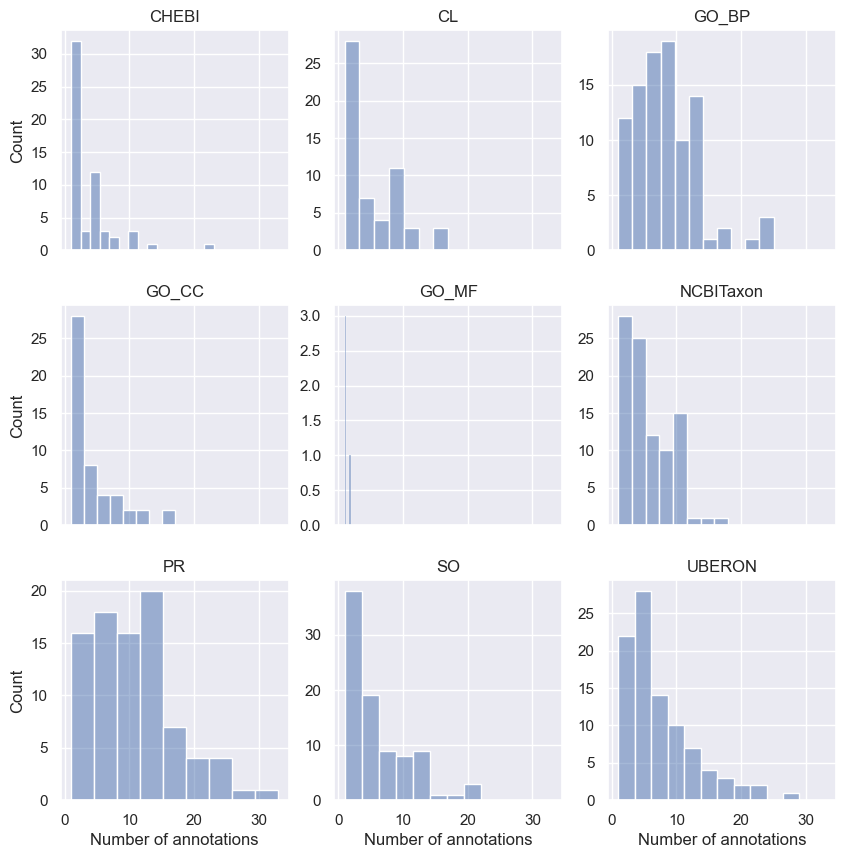

In [28]:
i = 0
sns.set_theme()
fig,axes = plt.subplots(3,3, figsize=(10,10),sharex=True)
plt.subplots_adjust(hspace=0.25)
for f in os.listdir(results_folder):
    ontology = os.path.join(results_folder,f)
    if os.path.isdir(ontology):
        annotations = pd.read_csv(os.path.join(ontology,'annotations.csv'))
        g = sns.histplot(annotations.rename(columns = {'Unnamed: 0':'id'}).groupby('PMID').agg(number_of_annotiaions = ('id',len)), 
        legend='', ax=axes[int(i/3),int(i%3)])
        g.set(title = f)
        if int(i%3) != 0:
            g.set(ylabel = '')
        if int(i/3) == 2: 
            g.set(xlabel='Number of annotations')

        i = i+1
plt.show()

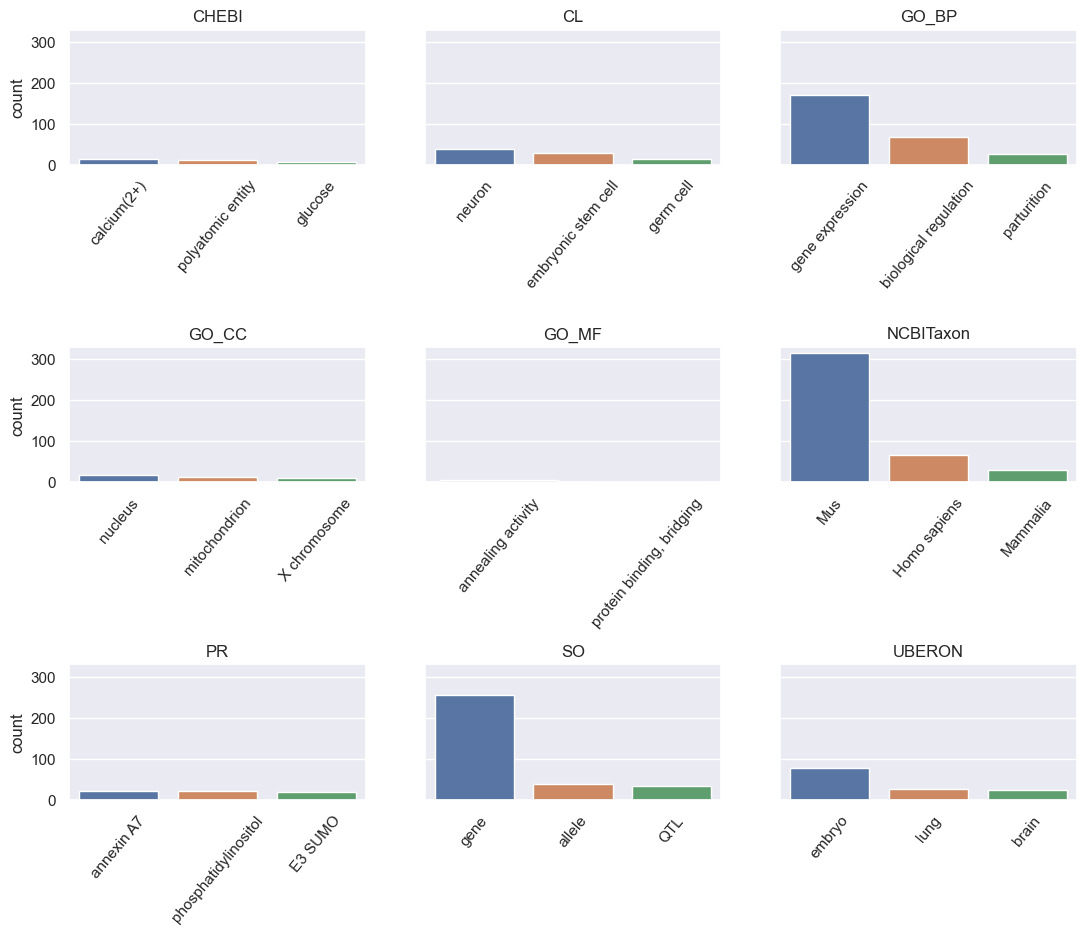

In [80]:
i = 0
sns.set_theme()
fig,axes = plt.subplots(3,3, figsize=(13,10),sharey=True)
plt.subplots_adjust(hspace=1.35)
for f in os.listdir(results_folder):
    ontology = os.path.join(results_folder,f)
    if os.path.isdir(ontology):
        annotations = pd.read_csv(os.path.join(ontology,'annotations.csv'))
        dt = pd.DataFrame(annotations['MentionTextSegment'].value_counts().iloc[:3]).reset_index().rename(columns = {'index':'concept','MentionTextSegment':'count'})
        # for two concepts the displayed text was cuuted to fit into plot
        dt = dt.replace({'phosphatidylinositol 3,4,5-trisphosphate 3-phosphatase and dual-specificity protein phosphatase PTEN':'phosphatidylinositol',
                'E3 SUMO-protein ligase RanBP2':'E3 SUMO'})
        g = sns.barplot(data = dt, x = 'concept',y = 'count',ax=axes[int(i/3),int(i%3)])
        g.set(title = f)
        if int(i%3) != 0:
            g.set(ylabel = '')
        g.set(xlabel='')
        axes[int(i/3),int(i%3)].tick_params(axis='x', rotation=50)


        i = i+1
plt.show()